<a href="https://colab.research.google.com/github/yueop/Classification-Practice/blob/main/Classification_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')   #구글 드라이브 연결
# Project_Path = '/content/drive/MyDrive/AS_LAB'  #저장할 폴더 경로 설정

# #저장할 폴더 존재 여부 확인(없으면 새 폴더 생성, 있으면 기존 폴더 사용)
# if not os.path.exists(Project_Path):
#     os.makedirs(Project_Path)
#     print(f"새 폴더 생성 후 저장 완료: {Project_Path}")
# else:
#     print(f"기존 폴더에 저장: {Project_Path}")

# %cd $Project_Path   #작업 위치 이동(change directory)

In [2]:
# 이 코드는 Ben Trevett의 튜토리얼을 참고하여 학습 목적으로 작성되었습니다.
# Source: https://github.com/bentrevett/pytorch-image-classification

#Data Precessing
import torch #일반적인 파이토치 기능(텐서 만들기 등)
import torch.nn as nn #신경망 층 쌓을 때 사용(nn.Linear, nn.CrossEntropyLoss 등)
import torch.nn.functional as F #nn의 함수 형태 기능들 사용
import torch.optim as optim #최적화(Optimizer) 도구들
import torch.utils.data as data #데이터를 쉽게 퍼나르기 위한 도구(DataLoader를 통해 데이터를 한 번에 몇 개씩(Batch)가져올지, 섞어서 (Shuffle)가져올지 결정)

import torchvision.transforms as transforms #이미지를 변형하는 도구
import torchvision.datasets as datasets #데이터셋을 모아놓은 라이브러리(datasets.MNIST 등)

from sklearn import metrics #정확도나 혼동행렬 계산시 사용(채점표)
from sklearn import decomposition #어려운 고차원 데이터를 2차원 평면으로 압축하여 시각화할 때 사용(PCA)
from sklearn import manifold #어려운 고차원 데이터를 2차원 평면으로 압축하여 시각화할 때 사용(t-SNE)
from tqdm.notebook import trange, tqdm #진행률 표시바(Progress bar)
import matplotlib.pyplot as plt #시각화 도구
import numpy as np #수치 계산시 사용

import copy #학습 중 성능이 가장 좋았던 모델의 가중치를 복사해서 저장해둘 때 사용
import random #실험결과를 똑같이 재현하기 위해 랜덤 시드를 고정할 때 사용
import time #학습시간 측정시 사용


In [3]:
#재현할 수 있는 결과를 얻게하기 위해 랜덤 시드 설정
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#데이터셋 로드하기
ROOT = '.data' #데이터가 저장될 위치 지정(폴더명)
train_data = datasets.MNIST(root=ROOT, #MNIST 데이터셋을 ROOT 위치에 저장
                            train=True, #학습용 데이터 로드(6만장)
                            download=True) #ROOT 위치에 데이터셋이 이미 있다면 다운로드 하지 않고, 없으면 다운로드

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.75MB/s]


In [5]:
#평균과 표준편차 구하기
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

In [6]:
print('평균: ', mean)
print('표준편차: ', std)

평균:  tensor(0.1307)
표준편차:  tensor(0.3081)


In [7]:
#데이터 증강(Rotation, Crop, ToTensor, Normalize)
train_transforms = transforms.Compose([ #훈련용 데이터
    transforms.RandomRotation(5, fill=(0,)), #이미지를 시계/반시계 방향으로 -5도에서 +5도 사이로 랜덤하게 회전 / fill=(0,): 이미지 회전시 귀퉁이에 생기는 빈 공간 0으로 채우기
    transforms.RandomCrop(28, padding=2), #28x28 이미지 테두리에 2픽셀씩 덧붙여 32x32크기로 키운 후 28x28 크기로 무작위 추출(이미지가 상하좌우로 이동하는 효과)
    transforms.ToTensor(), #그림 파일을 Tensor로 형변환(0~255의 값이 0~1 사이의 실수로 변형)
    transforms.Normalize(mean=[mean], std=[std]) #데이터에서 평균을 빼고, 표준편차로 나누기(데이터의 분포를 0 중심으로 모아 학습 효율 극대화)
])

test_transforms = transforms.Compose([ #실험용 데이터
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [8]:
#데이터 셋을 훈련용, 실험용으로 나누어 로드하고, 각각 데이터셋에 맞는 변형 선택
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [9]:
#데이터 개수 확인
print(f'훈련용 데이터 예제 수: {len(train_data)}')
print(f'실험용 데이터 예제 수: {len(test_data)}')

훈련용 데이터 예제 수: 60000
실험용 데이터 예제 수: 10000


In [10]:
#데이터 시각화
def plot_images(images):

  n_images = len(images) #이미지 개수

  rows = int(np.sqrt(n_images)) #이미지 개수의 제곱근
  cols = int(np.sqrt(n_images)) #이미지 개수의 제곱근

  fig = plt.figure() #그림이 그려질 곳(도화지)
  for i in range(rows*cols): #이미지 수만큼 반복
    ax = fig.add_subplot(rows, cols, i+1) #작은 그래프 하나 추가 / i+1: 그림 순서를 1번부터 세기 때문에 지정
    ax.imshow(images[i].view(28,28).cpu().numpy(), cmap='bone') #i번째 이미지 데이터를 꺼내 28x28크기의 이미지로 돌려놓고, 텐서를 CPU로 가져와서 넘파이 배열로 바꾸는 명령
    ax.axis('off') #그래프의 눈금 지우기

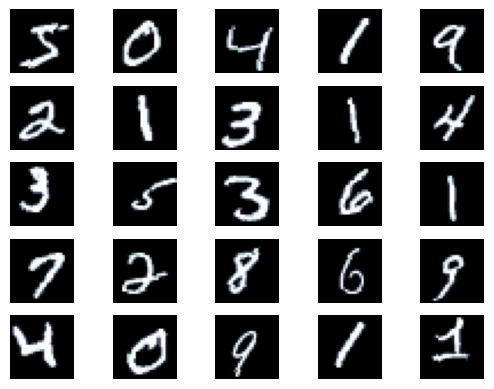

In [11]:
#함수 테스트
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [12]:
#Validation Set(검증용 데이터셋) 만들기
VALID_RATIO = 0.9

n_train_examples = int(len(train_data)*VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples #train_dataset의 10%를 Validation Set으로 사용

In [13]:
#검증용 데이터 랜덤 분할
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [14]:
#분할 수 확인
print(f'훈련용 데이터 개수: {len(train_data)}')
print(f'검증용 데이터 개수: {len(valid_data)}')
print(f'실험용 데이터 개수: {len(test_data)}')

훈련용 데이터 개수: 54000
검증용 데이터 개수: 6000
실험용 데이터 개수: 10000


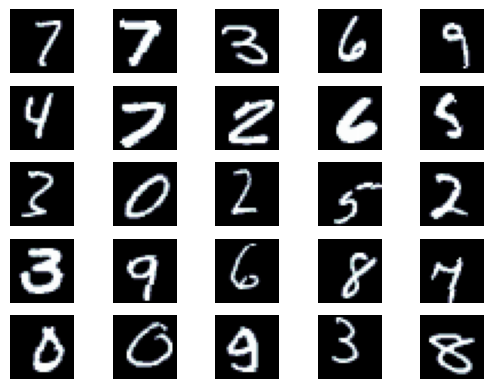

In [15]:
#검증용 데이터셋 확인
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [16]:
#얕은 복사 문제와 검증용 데이터셋의 변형 상태를 돌려놓기 위한 설정
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

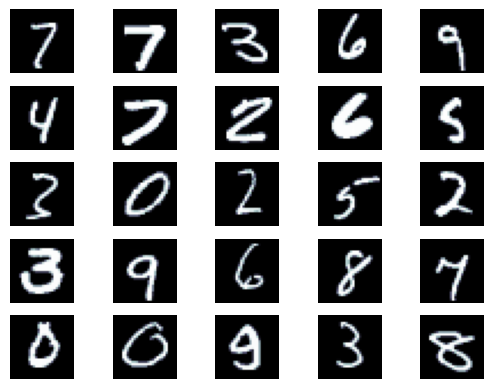

In [17]:
#설정 확인
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [20]:
#데이터 로더 만들기
BATCH_SIZE = 64 #한 번에 64개의 데이터를 모델에 입력하여 처리

train_iterator = data.DataLoader(train_data,
                                 shuffle=True, #매번 새로운 조합의 데이터 묶음을 보여준다.
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                  batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

shuffle=True: 훈련시에는 이미지의 순서를 보고 값을 예측하지 못하도록 매번 새로운 조합의 데이터 묶음을 보여주어 제대로 내용을 이해하도록 해준다(확률적 경사 하강법(SGD)의 핵심).

In [26]:
#Defining the Model
#MLP 클래스 구현

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim): #모델이 사용할 층들을 정의하는 함수
    super().__init__() #자식 클래스가 부모 클래스의 초기화 메소드를 호출하여 부모의 속성과 기능을 그대로 가져와 사용하는 코드

    self.input_fc = nn.Linear(input_dim, 250) #1층: 입력 -> 은닉층1(입력 데이터를 250차원의 특징 벡터로 변환(매핑))
    self.hidden_fc = nn.Linear(250, 100) #2층: 은닉층1 -> 은닉층2(250차원의 특징을 더 압축하여 100차원의 고급특징 벡터로 매핑)
    self.output_fc = nn.Linear(100, output_dim) #3층: 은닉층2 -> 출력(100차원의 특징 벡터를 보고 0~9까지의 클래스 확률로 변환)

  def forward(self, x): #데이터(x)가 실제로 들어왔을 때 모델을 어떤 순서로 통과할지 결정

    #현재 x = [batch size, height, width]

    #평탄화
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)

    #현재 x = [batch size, height*width]

    h_1 = F.relu(self.input_fc(x)) #784차원의 입력 벡터를 250차원의 특징 벡터로 변환(숫자의 기초적인 특징, ReLU를 이용해 불필요한 정보는 삭제)

    #은닉층1 h_1 = [batch size, 250]

    h_2 = F.relu(self.hidden_fc(h_1)) #250차원의 특징 벡터를 100차원의 특징 벡터로 압축(기초 특징들을 조합해 고차원적인 정보를 담은 특징 벡터로 압축)

    #은닉층2 h_2 = [batch size, 100]

    y_pred = self.output_fc(h_2) #100차원 특징 정보를 분석해 10개의 클래스 점수 계산

    #y_pred = [batch size, output dim]

    return y_pred, h_2 #y_pred: 최종 판결(정답), h_2: 판결을 내리기 위해 사용한 100차원 특징 벡터(시각화하여 모델 분석에 사용)

x.view(batch_size, -1): view 함수를 이용하여 차원 재구성(28x28 이미지를 1x784의 평면으로 변환)한다.
batch_size, -1 파라미터: x의 텐서 안에는 64(batch size), 1(channel), 28(width), 28(height)개를 곱한 50,176개의 데이터가 들어있다. view(batch_size, -1)함수가 작동하면 첫 번째 차원을 batch_size(64)로 고정하고, 다른 차원은 컴퓨터가 알아서 채우게 된다(50,176 / 64 = 784). 따라서 텐서의 모양은[64, 784]로 변하게 되고 이 것이 평탄화 작업이다.

In [30]:
#모델 정의 및 입출력차원 설정
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [31]:
#모델로 학습 가능한 파라미터(가중치, 편향)의 총 개수를 계산하는 함수 정의
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad) #학습 가능한(미분해야되는) 파라미터의 수 리턴

In [32]:
print(f'이 모델은 {count_parameters(model):,}개의 학습 가능한 파라미터를 가집니다.')

이 모델은 222,360개의 학습 가능한 파라미터를 가집니다.


In [ ]:
#Training The Model

